If you want to run this in colab, add 'tocolab' into the URL in your browser.
I.e., change '...github.com/eo2cube/...' to '...github**tocolab**.com/eo2cube/...' To use GEEs data, an GEE account is needed.

*Downloads* the odc-colab Python module and runs it to setup ODC. 

In [1]:
!wget -nc https://raw.githubusercontent.com/ceos-seo/odc-colab/master/odc_colab.py
from odc_colab import odc_colab_init
odc_colab_init(install_odc_gee=True)

--2021-09-20 15:08:54--  https://raw.githubusercontent.com/ceos-seo/odc-colab/master/odc_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14338 (14K) [text/plain]
Saving to: ‘odc_colab.py’

odc_colab.py        100%[===================>]  14.00K  --.-KB/s    in 0s      

2021-09-20 15:08:54 (70.6 MB/s) - ‘odc_colab.py’ saved [14338/14338]

Module utils was not found; cloning https://github.com/ceos-seo/data_cube_utilities.git to CWD...
Package postgresql was not found; installing it...
Module odc-gee was not found; cloning https://github.com/ceos-seo/odc-gee.git to CWD...


Downloads an existing index and populates the new ODC environment with it.

In [2]:
from odc_colab import populate_db
populate_db()

No database file supplied. Downloading default index.
Cleaned up extracted database files.


# Landsat Vegetation Phenology
This notebook calculates vegetation phenology changes using Landsat 7 and Landsat 8 data. To detect changes, the algorithm uses Normalized Difference Vegetation Index (NDVI) which is a common proxy for vegetation growth and health. The outputs of this notebook can be used to assess differences in agriculture fields over time or space and also allow the assessment of growing states such as planting and harvesting.  
<br>
There are two output products. The first output product is a time series boxplot of NDVI with the data binned by week, month, week of year, or month of year. The second output product is a time series lineplot of the mean NDVI for each year, with the data potentially binned by week or month. This product is useful for comparing different years to each other.

## Load Data Cube Configuration and Import Utilities

In [3]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Load Data Cube Configuration
from odc_gee import earthengine
dc = earthengine.Datacube(app='Phenology')

# Import Data Cube API
import utils.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi()

import xarray as xr
import numpy as np  
import matplotlib.pyplot as plt

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=Hf3f6-mowE7zuWFH1CewIpd0FzkJXrP1Hctkdde27dw&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWg3KehRolquH3lGMM2PrBfXCGbDsISOzpnoyy2l866pMY3L7p1qzOw

Successfully saved authorization token.


/usr/local/lib/python3.7/dist-packages/datacube/drivers/postgres/_connections.py:84: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,
/usr/local/lib/python3.7/dist-packages/datacube/drivers/postgres/_connections.py:84: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,


In [4]:
# Select a Product and Platform
product = "ls8_google"
platform = "LANDSAT_8"

## <span id="define_extents">Define the Extents of the Analysis [&#9652;](#top)</span>

In [42]:
# MODIFY HERE

# Select the center of an analysis region (lat_long) 
# Adjust the surrounding box size (box_size) around the center (in degrees)
# Remove the comment tags (#) below to change the sample location

# Maize Crops in Sudan Savanna, Ghana, Africa 
lat_long = (49.8025, 9.877)
box_size_deg = 0.003

# Calculate the latitude and longitude bounds of the analysis box
latitude = (lat_long[0]-box_size_deg/3, lat_long[0]+box_size_deg/3)
longitude = (lat_long[1]-box_size_deg/2, lat_long[1]+box_size_deg/2)

# Define Time Range 
# Landsat-8 time range: 07-Apr-2013 to current
# The format of the time date is YYYY-MM-DD
start_date = '2016-01-01'
end_date = '2020-12-31'
time_extents = (start_date, end_date)

In [43]:
# The code below renders a map that can be used to view the region.
from utils.data_cube_utilities.dc_display_map import display_map
display_map(latitude,longitude)

## Load bands needed for NDVI and remove clouds and water

In [51]:
landsat_dataset = dc.load(latitude = latitude,
                          longitude = longitude,
                          platform = platform,
                          time = time_extents,
                          product = product,
                          dask_chunks={"time": 1, "longitude": 1000, "latitude": 1000},
                          measurements = ['red', 'nir', 'pixel_qa']) 

In [52]:
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask
land_mask = landsat_qa_clean_mask(landsat_dataset, platform=platform, cover_types=['clear'])
landsat_dataset = landsat_dataset.drop('pixel_qa')
cleaned_dataset = landsat_dataset.where(land_mask)

## Define NDVI and add it to the dataset

In [53]:
def NDVI(dataset):
    return (dataset.nir - dataset.red)/(dataset.nir + dataset.red)

In [54]:
cleaned_dataset['NDVI'] = NDVI(cleaned_dataset)

## Plot NDVI vs Time in a Box-and-Whisker Plot

In [55]:
# MODIFY HERE

# Specify the target aggregation type of the curve fit. 
# Input can be either 'mean' or 'median'.
curve_fit_target = 'median'

# The maximum number of data points that appear along time in each plot.
# If more than this number of data points need to be plotted, a grid of plots will be created.
max_times_per_plot = 100

# Select the binning approach for the vegetation index. Choose one from the list below. 
#  None         = do not bin the data
# 'week'        = bin the data by week with an extended time axis
# 'month'       = bin the data by month with an extended time axis
# 'weekofyear'  = bin the data by week and years using a single year time axis
# 'monthofyear' = bin the data by month and years using a single year time axis
bin_by = 'monthofyear'

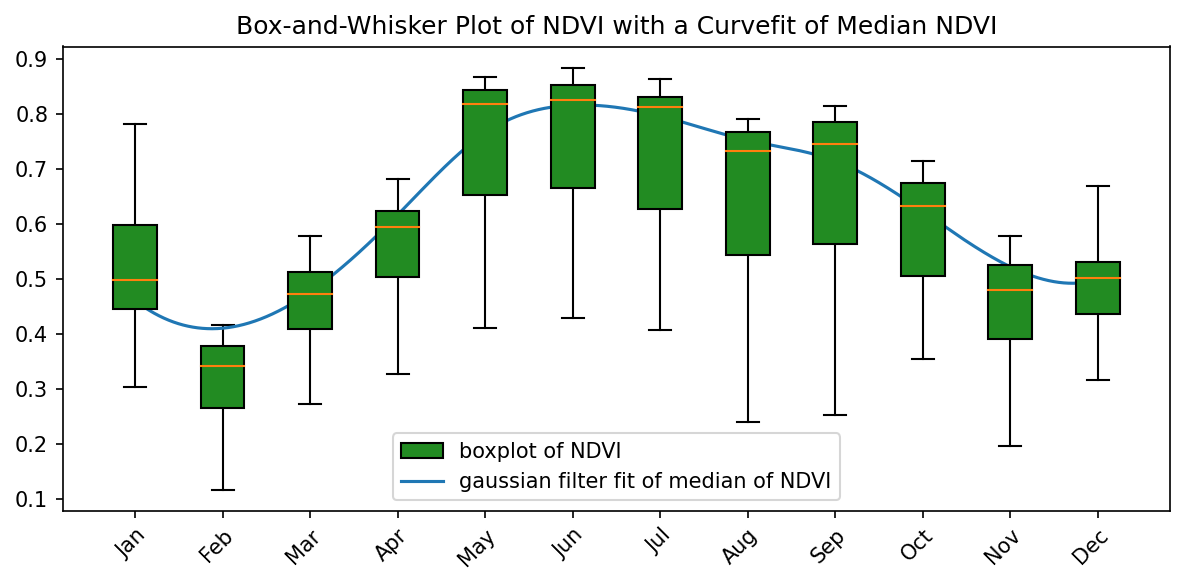

In [56]:
from utils.data_cube_utilities.plotter_utils import xarray_time_series_plot

veg_proxy = 'NDVI' 

aggregated_by_str = None
if bin_by is None:
    plotting_data = cleaned_dataset
elif bin_by == 'week':
    plotting_data = cleaned_dataset.resample(time='1w').mean()
    aggregated_by_str = 'Week'
elif bin_by == 'month':
    plotting_data = cleaned_dataset.resample(time='1m').mean()
    aggregated_by_str = 'Month'
elif bin_by == 'weekofyear':
    plotting_data = cleaned_dataset.groupby('time.week').mean(dim=('time'))
    aggregated_by_str = 'Week of Year'
elif bin_by == 'monthofyear':
    plotting_data = cleaned_dataset.groupby('time.month').mean(dim=('time'))
    aggregated_by_str = 'Month of Year'
    
params = dict(dataset=plotting_data, plot_descs={veg_proxy:{'none':[
    {'box':{'boxprops':{'facecolor':'forestgreen'}}}]}})

params['plot_descs'][veg_proxy][curve_fit_target] = [{'gaussian_filter':{}}]
    
fig, curve_fit_plotting_data = \
    xarray_time_series_plot(**params, fig_params=dict(figsize=(8,4), dpi=150), 
                            max_times_per_plot=max_times_per_plot)

plt.title('Box-and-Whisker Plot of {1} with a Curvefit of {0} {1}'
          .format(curve_fit_target.capitalize(), veg_proxy))
plt.tight_layout()
plt.show()

### Plot NDVI vs. Time for each year
Note that the curve fits here do not show where some times have no data, as is shown in the box-and-whisker plot. Notably, the curve interpolates over times with missing data that are not the first or last time (e.g. January or December for monthly binned data).

In [ ]:
# MODIFY HERE

# Select the binning approach for the vegetation index. Set the 'bin_by' parameter.
# 'weekofyear'  = bin the data by week and years using a single year time axis
# 'monthofyear' = bin the data by month and years using a single year time axis

bin_by = 'monthofyear'

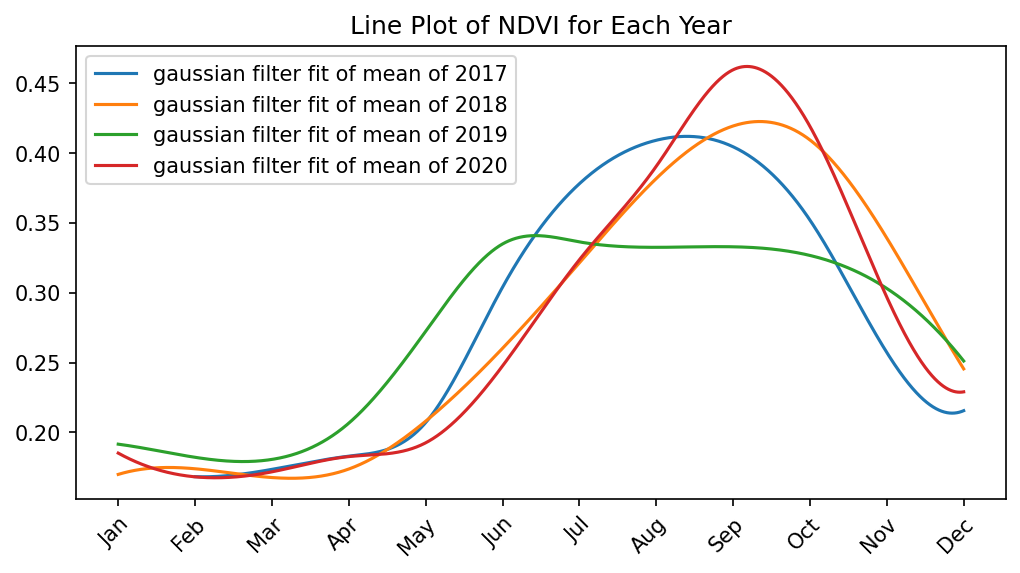

In [ ]:
years_with_data = []
plot_descs = {}
daysofyear_per_year = {}
plotting_data_years = {}
time_dim_name = None
for year in range(np.datetime64(start_date, 'Y').item().year, np.datetime64(end_date, 'Y').item().year+1):
    year_data = cleaned_dataset.sel(time=slice('{}-01-01'.format(year), '{}-12-31'.format(year)))[veg_proxy]
    if len(year_data['time']) == 0: # There is nothing to plot for this year.
        print("Year {} has no data, so will not be plotted.".format(year))
        continue
    years_with_data.append(year)
    
    spec_ind_dayofyear = year_data.groupby('time.dayofyear').mean()
    daysofyear_per_year[year] = spec_ind_dayofyear[~spec_ind_dayofyear.isnull().sum(dim='dayofyear')].dayofyear
    
    aggregated_by_str = None
    if bin_by == 'weekofyear':
        plotting_data_year = year_data.groupby('time.week').mean(dim=('time'))
        time_dim_name = 'week'
    elif bin_by == 'monthofyear':
        plotting_data_year = year_data.groupby('time.month').mean(dim=('time'))
        time_dim_name = 'month'

    plotting_data_years[year] = plotting_data_year
    num_time_pts = len(plotting_data_year[time_dim_name])
    
    # Select the curve-fit type. 
    # See the documentation for `xarray_time_series_plot()` regarding the `plot_descs` parameter.
    plot_descs[year] = {'mean':[{'gaussian_filter':{}}]}

time_dim_name = 'week' if bin_by == 'weekofyear' else 'month' if bin_by == 'monthofyear' else 'time'

num_times = 54 if bin_by == 'weekofyear' else 12
time_coords_arr = np.arange(1, num_times+1) # In xarray, week and month indices start at 1.
time_coords_da = xr.DataArray(time_coords_arr, coords={time_dim_name:time_coords_arr}, 
                              dims=[time_dim_name], name=time_dim_name)
coords = dict(list(plotting_data_years.values())[0].coords)
coords[time_dim_name] = time_coords_da 
plotting_data = xr.Dataset(plotting_data_years, coords=coords)
params = dict(dataset=plotting_data, plot_descs=plot_descs)

xarray_time_series_plot(**params, fig_params=dict(figsize=(8,4), dpi=150))
plt.title('Line Plot of {0} for Each Year'.format(veg_proxy))
plt.show()